<a href="https://colab.research.google.com/github/ValentinVignal/HDStyleTransfert/blob/st%2Fgoogle-colab/style_transfert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HD Style transfert

## Utilisation

1. Create 1 folders on your computer names *content* and *style*
2. Put the corresponding images in it
3. Creat 2 `.zip` files: `content.zip` and `style.zip`
4. Import them in the session (column on the left)
5. Run everything

## What it does

It does all the combinaison of the content and style files and do the style transfert. It saves everything in the folder *results* with the architecture:
```bash
results/
 |- content_image_name1/
 |  |- style_image_name1/
 |  |  |- n_step.png          # The style transfered image at the step n
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- content_image_name2/
 |  |- style_image_name1/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- style_image_name2/
 |  |  |- n_step.png
 |  |  |- 2n_step.png
 |  |  |- ...
 |  |- ...
 |- ...

```

## To keep the environment connected

1. Press `Ctrl` + ` Shift` + `i`
2. Go to *Console*
3. Paste these lines:
  ```javascript
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
  }
  setInterval(ClickConnect,60000);
  ```
4. Press `Enter`

## To allow the download

You need to enable third-party cookies but for now it only works for Chrome browser, open
```
chrome://settings/content/cookies
```
make sure the option for Block third-party cookies is disabled and click add button in Allow section then add
```
colab.research.google.com
```

# Parameters

You can customize the parameters by changing the value in the following dictionaries (the `None` value is considered as the default value).

Check out the default values in [this folder](https://github.com/ValentinVignal/HDStyleTransfert/tree/master/src/variables).

For the layers, here are all the choices: (use a conv block)

input_2 block1_conv1 block1_conv2 block1_pool block2_conv1 block2_conv2 block2_pool block3_conv1 block3_conv2 block3_conv3 block3_conv4 block3_pool block4_conv1 block4_conv2 block4_conv3 block4_conv4 block4_pool block5_conv1 block5_conv2 block5_conv3 block5_conv4 block5_pool


In [0]:
# Parameters
parameters = {
  "st_mode": "noise",
  "img_size": 1024,   # Size of the generated image
  "img_size_nn": None,
  "dim_size": None,   # Axis of the chosen size of the image
  "style_weight": None,    # Importance of style
  "content_weight": 1e5,    # Importance of content
  "content_gram_weight": 0,   # Importance of content when the start image is not the content image
  "content_weight_multiplicator": 10, # Multiply content importance when the starting image is not the content image
  "total_variation_weight" : None,   # How much to reduce high frequencies
  "epochs": 10,   # Number of epochs
  "steps_per_epoch": None,    # Number of steps per epoch
  "lr": None,    # Learning rate
  "content_layers": None,   # List of names of the content layers
  "content_gram_layers": None,    # The layers of the content gram
  "style_layers": None,   # List of names of the style layers
  "image_start": ['content', 'style'],  # Options for the start image
}

# Setup

In [2]:
# Install tensorflow
try:
  # %tensroflow_version only exists in Colab
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.test.gpu_device_name())
print('tf version', tf.__version__)

/device:GPU:0
tf version 2.2.0


In [3]:
# Clone the github repo
!git init
!git clone https://github.com/ValentinVignal/HDStyleTransfert.git
# Go in it
%cd HDStyleTransfert/

Initialized empty Git repository in /content/.git/
Cloning into 'HDStyleTransfert'...
remote: Enumerating objects: 162, done.
remote: Counting objects: 100% (162/162), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 394 (delta 79), reused 115 (delta 53), pack-reused 232
Receiving objects: 100% (394/394), 11.59 MiB | 19.46 MiB/s, done.
Resolving deltas: 100% (209/209), done.
/content/HDStyleTransfert


In [4]:
# Install dependencies except tensorflow
%pip install $(grep -ivE "tensorflow|Pillow|ipython" requirements.txt)

     |████████████████████████████████| 20.2MB 1.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


In [0]:
%matplotlib inline

In [0]:
from epicpath import EPath
import json

# Save the variables files
parameters_path = EPath('style_transfert_parameters.json')
with open(parameters_path, 'w') as json_file:
  json.dump(parameters, json_file)

In [0]:
# %cd HDStyleTransfert/
# !rm -r results
# !rm style_transfert_parameters.json
# !git pull

/content/HDStyleTransfert


# Run

In [0]:
all_images = True     # To do all the combinaisons of the images

Combination  2/40 (  5%) [-->                                               ] Time 0:14:38 ETA 4:38:12


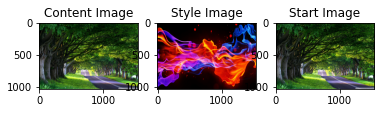

Epoch  0/10 (  0%) [.                   ] Time 0:00:00
Step 20/20 (100%) [....................] Time 0:00:07


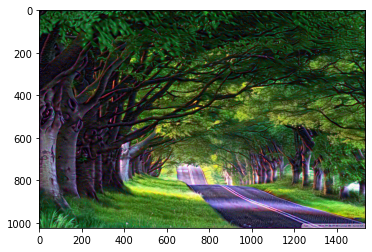

Epoch  1/10 ( 10%) [...                 ] Time 0:00:09
Step 40/40 (100%) [....................] Time 0:00:14


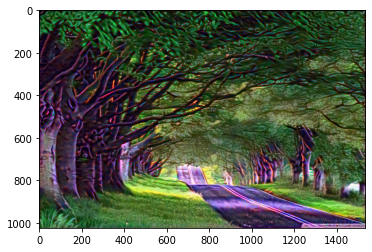

Epoch  2/10 ( 20%) [.....               ] Time 0:00:25
Step 60/60 (100%) [....................] Time 0:00:21


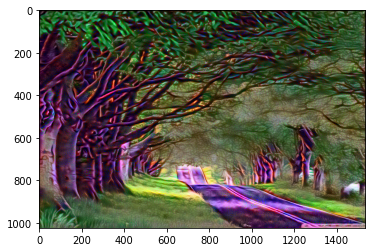

Epoch  3/10 ( 30%) [.......             ] Time 0:00:49
Step 80/80 (100%) [....................] Time 0:00:29


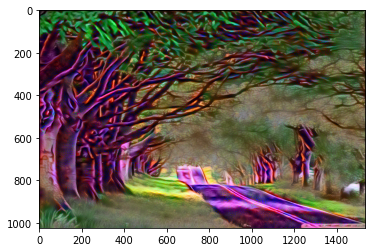

Epoch  4/10 ( 40%) [.........           ] Time 0:01:21
Step 100/100 (100%) [....................] Time 0:00:36


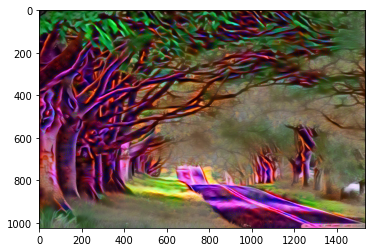

Epoch  5/10 ( 50%) [...........         ] Time 0:02:00
Step 120/120 (100%) [....................] Time 0:00:44


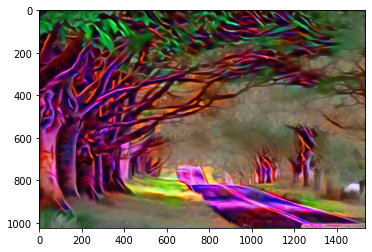

Epoch  6/10 ( 60%) [.............       ] Time 0:02:46
Step  76/140 ( 54%) [...........         ] ETA 0:00:24

In [0]:
import os
import src
from loadbar import RainbowBar
import IPython.display as display

content_path_list, style_path_list = src.st.data.get_data()
num_content = len(content_path_list)
num_style = len(style_path_list)
num_image_start = src.st.data.get_num_image_start(num_content, num_style)
nb_combinations = num_content * num_style * num_image_start
print(f'{nb_combinations} combinations ({num_content} contents, {num_style} styles, {num_image_start} starts)')
bar = RainbowBar( max=nb_combinations, size=50, head='>', body='-', title='Combination', show_time=True)
bar.start()
for i in range(nb_combinations):
  if i > 0: display.clear_output(wait=True)
  # I launch a different process to solve the leak memory issue in tensorflow.
  # When the process is finished, at least everything about this one is cleaned and I can start again peacefully
  # and there is no memory issue anymore :)
  bar.update(step=i, end='\n')
  %run style_transfert.py
  if not all_images:
    # Do only one image
    break
bar.end()

# Save and download

In [0]:
# Zip it
!zip -r results.zip results

  adding: results/ (stored 0%)
  adding: results/rose/ (stored 0%)
  adding: results/rose/clouds/ (stored 0%)
  adding: results/rose/clouds/hub.png (deflated 0%)
  adding: results/rose/xperia_z/ (stored 0%)
  adding: results/rose/xperia_z/hub.png (deflated 0%)
  adding: results/rose/piano/ (stored 0%)
  adding: results/rose/piano/hub.png (deflated 0%)
  adding: results/rose/surface pro/ (stored 0%)
  adding: results/rose/surface pro/hub.png (deflated 0%)
  adding: results/tree_road/ (stored 0%)
  adding: results/tree_road/clouds/ (stored 0%)
  adding: results/tree_road/clouds/hub.png (deflated 0%)
  adding: results/tree_road/xperia_z/ (stored 0%)
  adding: results/tree_road/xperia_z/hub.png (deflated 0%)
  adding: results/tree_road/piano/ (stored 0%)
  adding: results/tree_road/piano/hub.png (deflated 0%)
  adding: results/tree_road/surface pro/ (stored 0%)
  adding: results/tree_road/surface pro/hub.png (deflated 0%)
  adding: results/for_mustang/ (stored 0%)
  adding: results/for_mus

In [0]:
# Download it
from google.colab import files


is_downloaded = False
i = 0
while not is_downloaded:
  try:
    files.download('results.zip')
    is_downloaded = True
  except Exception as e:
    i += 1
    print(i, e)
  if i == 100:
    print('Could not download')
    break

# If this part doesn't work, see the section "To allow the download" at the beginning

1 TypeError: Failed to fetch
2 TypeError: Failed to fetch
3 TypeError: Failed to fetch
4 TypeError: Failed to fetch
5 TypeError: Failed to fetch
6 TypeError: Failed to fetch
7 TypeError: Failed to fetch
8 TypeError: Failed to fetch
9 TypeError: Failed to fetch
10 TypeError: Failed to fetch
11 TypeError: Failed to fetch
12 TypeError: Failed to fetch
13 TypeError: Failed to fetch
14 TypeError: Failed to fetch
15 TypeError: Failed to fetch
16 TypeError: Failed to fetch
17 TypeError: Failed to fetch
18 TypeError: Failed to fetch
19 TypeError: Failed to fetch
20 TypeError: Failed to fetch
21 TypeError: Failed to fetch
22 TypeError: Failed to fetch
23 TypeError: Failed to fetch
24 TypeError: Failed to fetch
25 TypeError: Failed to fetch
26 TypeError: Failed to fetch
27 TypeError: Failed to fetch
28 TypeError: Failed to fetch
29 TypeError: Failed to fetch
30 TypeError: Failed to fetch
31 TypeError: Failed to fetch
32 TypeError: Failed to fetch
33 TypeError: Failed to fetch
34 TypeError: Faile

End :)